In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


Dataset shape: (23195, 130)

Countries: 314
Years: 1900 - 2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Columns: 130 entries, country to wind_share_energy
dtypes: float64(127), int64(1), object(2)
memory usage: 23.0+ MB


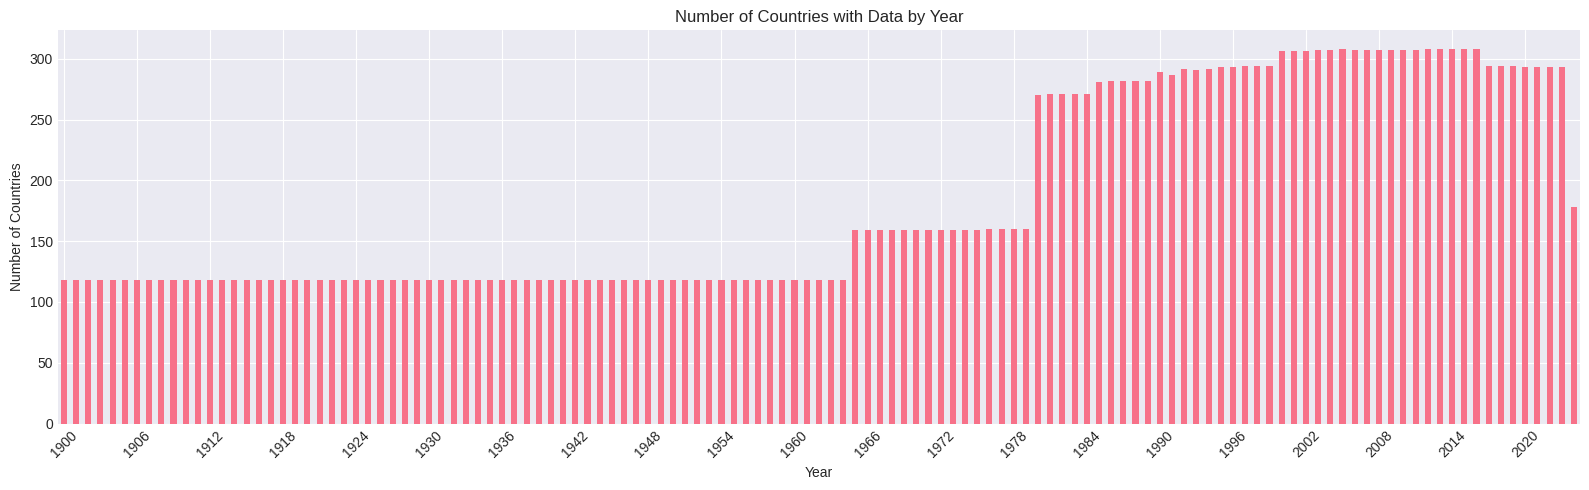

In [2]:
df = pd.read_csv('owid-energy-data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nCountries: {df['country'].nunique()}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")

# Display basic info
df.info()
# Check data coverage by year
yearly_counts = df.groupby('year')['country'].count()
plt.figure(figsize=(16, 5))  
yearly_counts.plot(kind='bar')
plt.title('Number of Countries with Data by Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')

years = yearly_counts.index
step = max(1, len(years) // 20)  
plt.xticks(range(0, len(years), step), years[::step], rotation=45)
plt.tight_layout()
plt.show()

Transition features created for 308 countries


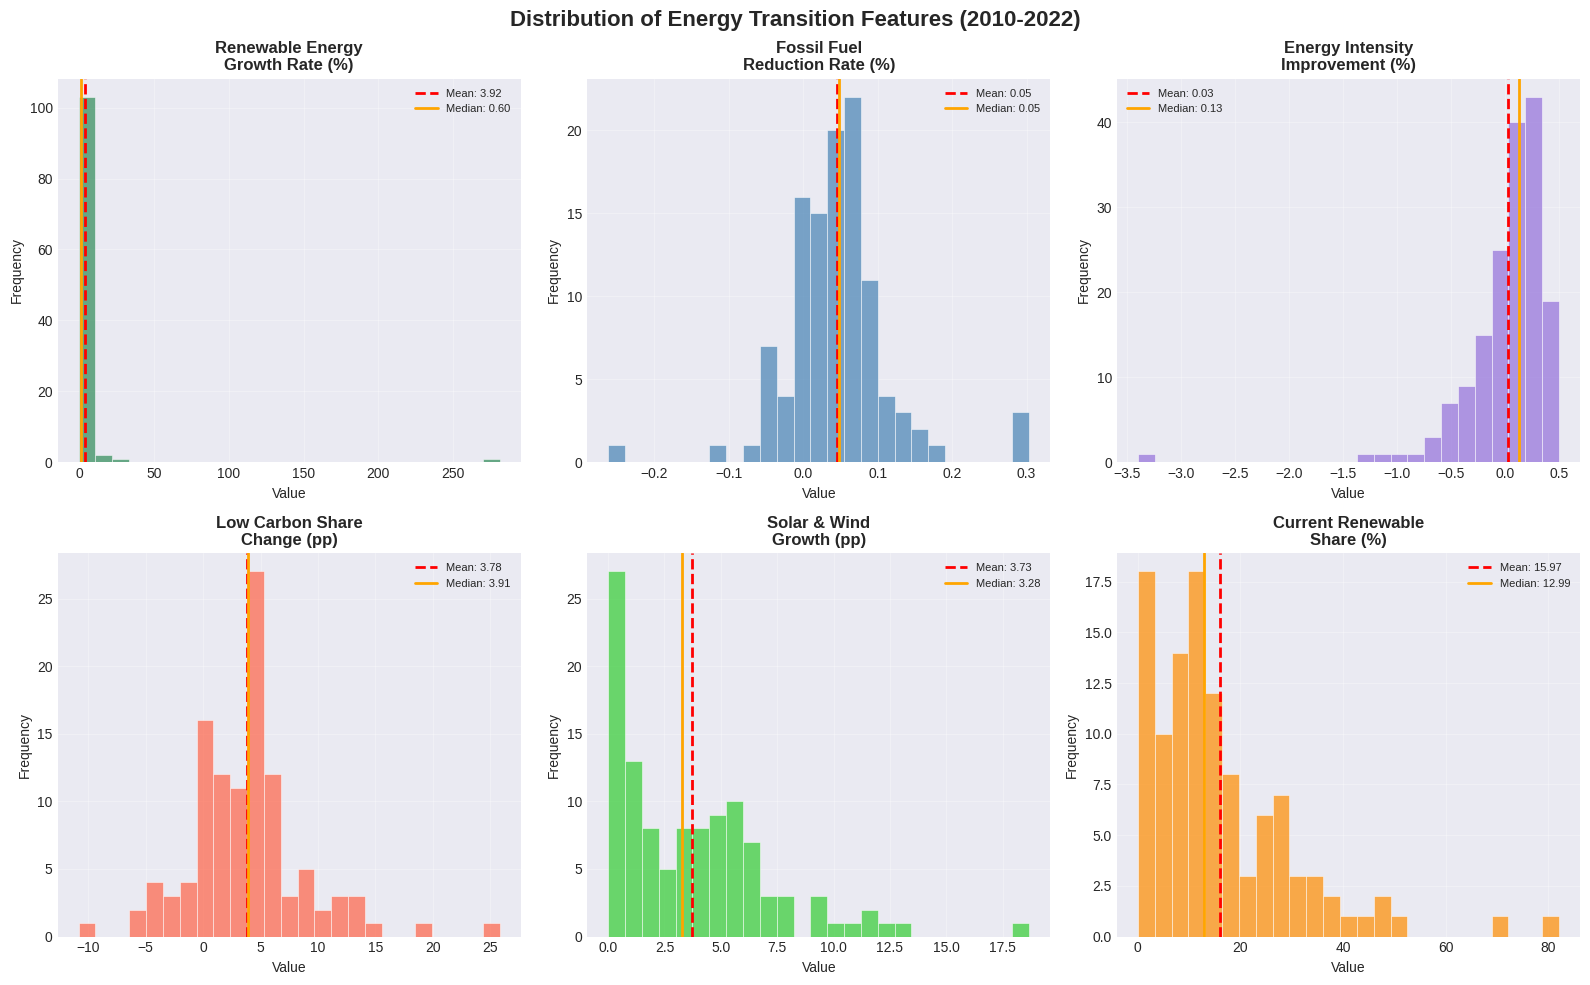

In [4]:
## 3. Feature Engineering

def create_transition_features(df, start_year=2010, end_year=2022):
    """
    Create energy transition features for clustering
    Focus on recent transition patterns (2010-2022)
    """
    
    # Filter data for the analysis period
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    
    # Calculate country-level transition metrics
    transition_features = []
    
    for country in df_period['country'].unique():
        country_data = df_period[df_period['country'] == country].sort_values('year')
        
        if len(country_data) < 5:  # Skip countries with insufficient data
            continue
            
        features = {'country': country}
        
        # 1. Renewable energy growth rate
        renewable_start = country_data['renewables_share_energy'].iloc[0]
        renewable_end = country_data['renewables_share_energy'].iloc[-1]
        if pd.notna(renewable_start) and renewable_start > 0:
            features['renewable_growth_rate'] = (renewable_end - renewable_start) / renewable_start
        else:
            features['renewable_growth_rate'] = np.nan
            
        # 2. Fossil fuel reduction rate
        fossil_start = country_data['fossil_share_energy'].iloc[0]
        fossil_end = country_data['fossil_share_energy'].iloc[-1]
        if pd.notna(fossil_start) and fossil_start > 0:
            features['fossil_reduction_rate'] = (fossil_start - fossil_end) / fossil_start
        else:
            features['fossil_reduction_rate'] = np.nan
            
        # 3. Energy intensity improvement
        energy_intensity_start = country_data['energy_per_gdp'].iloc[0]
        energy_intensity_end = country_data['energy_per_gdp'].iloc[-1]
        if pd.notna(energy_intensity_start) and energy_intensity_start > 0:
            features['energy_intensity_improvement'] = (energy_intensity_start - energy_intensity_end) / energy_intensity_start
        else:
            features['energy_intensity_improvement'] = np.nan
            
        # 4. Low carbon share change
        low_carbon_start = country_data['low_carbon_share_energy'].iloc[0]
        low_carbon_end = country_data['low_carbon_share_energy'].iloc[-1]
        features['low_carbon_change'] = low_carbon_end - low_carbon_start if pd.notna(low_carbon_start) else np.nan
        
        # 5. Solar and wind adoption rate
        solar_wind_start = (country_data['solar_share_energy'].iloc[0] + country_data['wind_share_energy'].iloc[0])
        solar_wind_end = (country_data['solar_share_energy'].iloc[-1] + country_data['wind_share_energy'].iloc[-1])
        features['solar_wind_growth'] = solar_wind_end - solar_wind_start if pd.notna(solar_wind_start) else np.nan
        
        # 6. Current state indicators (latest year)
        latest_data = country_data.iloc[-1]
        features['current_renewable_share'] = latest_data['renewables_share_energy']
        features['current_fossil_share'] = latest_data['fossil_share_energy']
        features['current_energy_per_capita'] = latest_data['energy_per_capita']
        features['current_carbon_intensity'] = latest_data['carbon_intensity_elec']
        
        # 7. GDP per capita (for developed/developing classification)
        features['gdp_per_capita'] = latest_data['gdp'] / latest_data['population'] if pd.notna(latest_data['gdp']) and pd.notna(latest_data['population']) else np.nan
        
        transition_features.append(features)
    
    return pd.DataFrame(transition_features)

# Create transition features
transition_df = create_transition_features(df)
print(f"Transition features created for {len(transition_df)} countries")
transition_df.head()



# 改进版本
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# 使用不同颜色区分特征类型
colors = ['#2E8B57', '#4682B4', '#9370DB', '#FF6347', '#32CD32', '#FF8C00']
feature_names = {
    'renewable_growth_rate': 'Renewable Energy\nGrowth Rate (%)',
    'fossil_reduction_rate': 'Fossil Fuel\nReduction Rate (%)', 
    'energy_intensity_improvement': 'Energy Intensity\nImprovement (%)',
    'low_carbon_change': 'Low Carbon Share\nChange (pp)',
    'solar_wind_growth': 'Solar & Wind\nGrowth (pp)',
    'current_renewable_share': 'Current Renewable\nShare (%)'
}

for i, col in enumerate(feature_names):
    # 添加统计信息
    mean_val = transition_df[col].mean()
    median_val = transition_df[col].median()
    
    # 绘制直方图
    axes[i].hist(transition_df[col].dropna(), bins=25, alpha=0.7, 
                color=colors[i], edgecolor='white', linewidth=0.5)
    
    # 添加均值和中位数线
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='orange', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    
    # 改进标题和标签
    axes[i].set_title(feature_names[col], fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribution of Energy Transition Features (2010-2022)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [6]:
## 3. Feature Engineering and Data Quality Control

# 3.1 Check data quality
print("=== Original Data Quality Check ===\n")

# Check data completeness for key fields
def check_data_completeness(df, start_year=2010, end_year=2022):
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    completeness = df_period.groupby('country').agg({
        'renewables_share_energy': lambda x: x.notna().sum(),
        'fossil_share_energy': lambda x: x.notna().sum(),
        'energy_per_gdp': lambda x: x.notna().sum(),
        'gdp': lambda x: x.notna().sum()
    }).rename(columns={
        'renewables_share_energy': 'renewable_data_points',
        'fossil_share_energy': 'fossil_data_points',
        'energy_per_gdp': 'energy_intensity_points',
        'gdp': 'gdp_data_points'
    })
    
    return completeness

completeness_df = check_data_completeness(df)
print(f"Countries with renewable energy data: {(completeness_df['renewable_data_points'] > 0).sum()}")
print(f"Countries with fossil fuel data: {(completeness_df['fossil_data_points'] > 0).sum()}")
print(f"Countries with both data types: {((completeness_df['renewable_data_points'] > 0) & (completeness_df['fossil_data_points'] > 0)).sum()}")

# 3.2 Select only countries with actual energy data
valid_countries = completeness_df[
    (completeness_df['renewable_data_points'] >= 3) & 
    (completeness_df['fossil_data_points'] >= 3)
].index.tolist()

print(f"\nNumber of valid countries after filtering: {len(valid_countries)}")

# 3.3 Improved feature engineering function
def create_transition_features_v2(df, valid_countries, start_year=2010, end_year=2022):
    """Process data for valid countries only"""
    
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    # Keep only valid countries
    df_period = df_period[df_period['country'].isin(valid_countries)]
    
    transition_features = []
    
    for country in valid_countries:
        country_data = df_period[df_period['country'] == country].sort_values('year')
        
        if len(country_data) == 0:
            continue
            
        features = {'country': country}
        
        # 1. Renewable energy growth rate (using non-null start and end values)
        renewable_series = country_data['renewables_share_energy'].dropna()
        if len(renewable_series) >= 2:
            start_val = renewable_series.iloc[0]
            end_val = renewable_series.iloc[-1]
            if start_val > 0:
                features['renewable_growth_rate'] = (end_val - start_val) / start_val
            else:
                features['renewable_growth_rate'] = end_val - start_val  # absolute growth
        else:
            features['renewable_growth_rate'] = 0
            
        # 2. Fossil fuel reduction rate
        fossil_series = country_data['fossil_share_energy'].dropna()
        if len(fossil_series) >= 2:
            start_val = fossil_series.iloc[0]
            end_val = fossil_series.iloc[-1]
            if start_val > 0:
                features['fossil_reduction_rate'] = (start_val - end_val) / start_val
            else:
                features['fossil_reduction_rate'] = 0
        else:
            features['fossil_reduction_rate'] = 0
            
        # 3. Energy intensity improvement
        energy_intensity_series = country_data['energy_per_gdp'].dropna()
        if len(energy_intensity_series) >= 2:
            start_val = energy_intensity_series.iloc[0]
            end_val = energy_intensity_series.iloc[-1]
            if start_val > 0:
                features['energy_intensity_improvement'] = (start_val - end_val) / start_val
            else:
                features['energy_intensity_improvement'] = 0
        else:
            features['energy_intensity_improvement'] = 0
            
        # 4. Low carbon energy change
        low_carbon_series = country_data['low_carbon_share_energy'].dropna()
        if len(low_carbon_series) >= 2:
            features['low_carbon_change'] = low_carbon_series.iloc[-1] - low_carbon_series.iloc[0]
        else:
            features['low_carbon_change'] = 0
            
        # 5. Solar and wind energy growth
        solar_series = country_data['solar_share_energy'].fillna(0)
        wind_series = country_data['wind_share_energy'].fillna(0)
        solar_wind_start = solar_series.iloc[0] + wind_series.iloc[0]
        solar_wind_end = solar_series.iloc[-1] + wind_series.iloc[-1]
        features['solar_wind_growth'] = solar_wind_end - solar_wind_start
        
        # 6. Current state (using latest non-null values)
        latest_renewable = country_data['renewables_share_energy'].dropna()
        features['current_renewable_share'] = latest_renewable.iloc[-1] if len(latest_renewable) > 0 else 0
        
        latest_fossil = country_data['fossil_share_energy'].dropna()
        features['current_fossil_share'] = latest_fossil.iloc[-1] if len(latest_fossil) > 0 else 100
        
        latest_per_capita = country_data['energy_per_capita'].dropna()
        features['current_energy_per_capita'] = latest_per_capita.iloc[-1] if len(latest_per_capita) > 0 else 0
        
        # 7. GDP per capita
        gdp_series = country_data['gdp'].dropna()
        pop_series = country_data['population'].dropna()
        if len(gdp_series) > 0 and len(pop_series) > 0:
            latest_gdp = gdp_series.iloc[-1]
            latest_pop = pop_series.iloc[-1]
            features['gdp_per_capita'] = latest_gdp / latest_pop if latest_pop > 0 else 0
        else:
            features['gdp_per_capita'] = 0
            
        transition_features.append(features)
    
    return pd.DataFrame(transition_features)

# 3.4 Create clean feature dataframe
transition_df = create_transition_features_v2(df, valid_countries)
print(f"\nFinal dataset contains complete data for {len(transition_df)} countries")

# 3.5 Validate data quality
print("\nData Quality Validation:")
print(f"renewable_growth_rate non-null values: {transition_df['renewable_growth_rate'].notna().sum()}")
print(f"fossil_reduction_rate non-null values: {transition_df['fossil_reduction_rate'].notna().sum()}")
print(f"current_renewable_share non-null values: {transition_df['current_renewable_share'].notna().sum()}")

# Display some examples
print("\nData Sample:")
print(transition_df[['country', 'renewable_growth_rate', 'fossil_reduction_rate', 'current_renewable_share']].head(10))

=== Original Data Quality Check ===

Countries with renewable energy data: 111
Countries with fossil fuel data: 111
Countries with both data types: 111

Number of valid countries after filtering: 111

Final dataset contains complete data for 111 countries

Data Quality Validation:
renewable_growth_rate non-null values: 111
fossil_reduction_rate non-null values: 111
current_renewable_share non-null values: 111

Data Sample:
             country  renewable_growth_rate  fossil_reduction_rate  \
0             Africa               0.324228               0.019574   
1        Africa (EI)               0.324228               0.019574   
2            Algeria               1.111111               0.001201   
3          Argentina               0.082762               0.007134   
4               Asia               1.025413               0.059558   
5  Asia Pacific (EI)               1.071019               0.069329   
6          Australia               2.240460               0.095494   
7            

In [7]:
## 4. Data Preprocessing

# Select features for clustering
clustering_features = [
    'renewable_growth_rate', 
    'fossil_reduction_rate', 
    'energy_intensity_improvement', 
    'low_carbon_change', 
    'solar_wind_growth', 
    'current_renewable_share', 
    'current_fossil_share'
]

# Create feature matrix
X = transition_df[clustering_features].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Create a dataframe with scaled features
X_scaled_df = pd.DataFrame(
    X_scaled, 
    columns=clustering_features, 
    index=transition_df.index
)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Missing values after imputation: {np.isnan(X_scaled).sum()}")

Feature matrix shape: (111, 7)
Missing values after imputation: 0


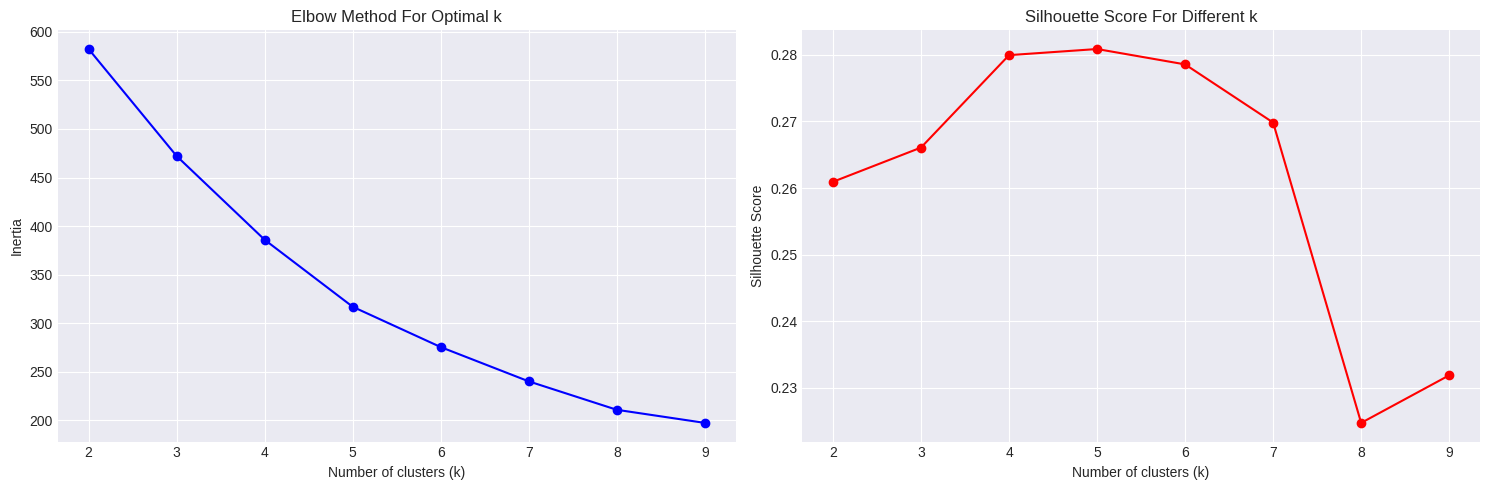

K-means clustering completed with 4 clusters

Cluster sizes:
kmeans_cluster
0    58
1     4
2     1
3    48
Name: count, dtype: int64


In [8]:
## 5. K-means Clustering

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')
ax1.grid(True)

ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score For Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Perform K-means with optimal k (let's use k=4 based on the elbow)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
transition_df['kmeans_cluster'] = kmeans_labels

print(f"K-means clustering completed with {optimal_k} clusters")
print("\nCluster sizes:")
print(transition_df['kmeans_cluster'].value_counts().sort_index())

=== Safe Isolation Forest Outlier Detection ===

Isolation Forest Results:
Number of outliers: 11 (9.9%)
Number of normal countries: 100

Outlier Countries:
 1. Azerbaijan                (anomaly score: -0.013)
 2. Denmark                   (anomaly score: -0.187)
 3. Finland                   (anomaly score: -0.092)
 4. Iceland                   (anomaly score: -0.153)
 5. Norway                    (anomaly score: -0.080)
 6. Other CIS (EI)            (anomaly score: -0.037)
 7. Other South America (EI)  (anomaly score: -0.161)
 8. Sweden                    (anomaly score: -0.128)
 9. United Arab Emirates      (anomaly score: -0.124)
10. United Kingdom            (anomaly score: -0.040)
11. Venezuela                 (anomaly score: -0.050)


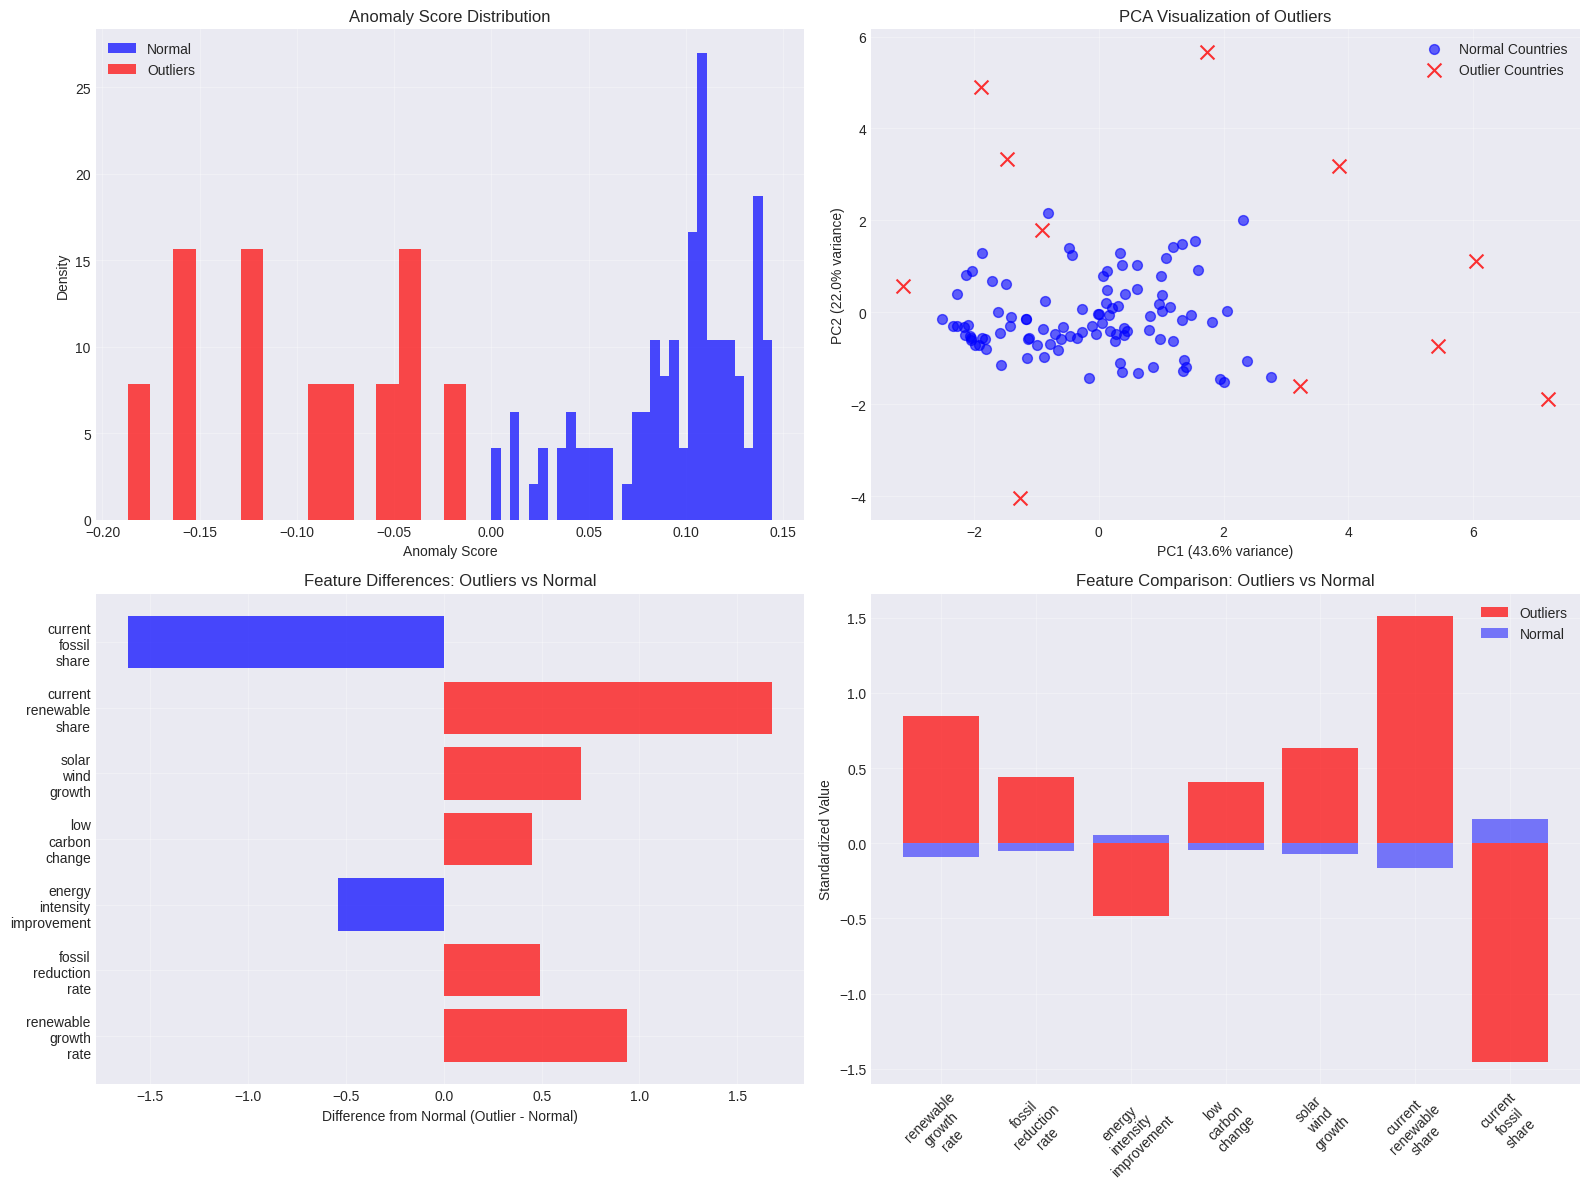


=== Feature Analysis ===

Feature Comparison (Outliers vs Normal):
Feature                      Outlier Mean Normal Mean  Difference  
----------------------------------------------------------------------
renewable_growth_rate            26.248      1.327     24.921 ↑
fossil_reduction_rate             0.077      0.042      0.035 ↑
energy_intensity_improvement      0.004      0.117     -0.113 ↓
low_carbon_change                 5.846      3.557      2.289 ↑
solar_wind_growth                 5.903      3.489      2.414 ↑
current_renewable_share          37.638     13.590     24.049 ↑
current_fossil_share             57.495     83.057    -25.562 ↓

=== Top 5 Most Anomalous Countries ===

1. Denmark (anomaly score: -0.187)
   Key characteristics:
     - Fossil Reduction Rate: very high (+5.8σ)
     - Low Carbon Change: very high (+5.7σ)
     - Solar Wind Growth: very high (+5.2σ)
     - Current Renewable Share: very high (+2.6σ)
     - Current Fossil Share: very low (-2.0σ)

2. Other Sou

In [9]:
## Safe Isolation Forest Outlier Detection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("=== Safe Isolation Forest Outlier Detection ===\n")

# 1. Apply Isolation Forest with optimal parameters
contamination_rate = 0.10  # 10% outliers
iso_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_estimators=200,
    max_samples='auto'
)

# Fit and predict
outlier_labels = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.decision_function(X_scaled)

# Add results to dataframe safely
transition_df_copy = transition_df.copy()
transition_df_copy['is_outlier'] = (outlier_labels == -1)
transition_df_copy['anomaly_score'] = anomaly_scores

n_outliers = np.sum(outlier_labels == -1)
outlier_ratio = n_outliers / len(outlier_labels)

print(f"Isolation Forest Results:")
print(f"Number of outliers: {n_outliers} ({outlier_ratio:.1%})")
print(f"Number of normal countries: {len(outlier_labels) - n_outliers}")

# 2. Identify outlier countries
outlier_countries = transition_df_copy[transition_df_copy['is_outlier']]['country'].tolist()
print(f"\nOutlier Countries:")
for i, country in enumerate(sorted(outlier_countries), 1):
    score = transition_df_copy[transition_df_copy['country'] == country]['anomaly_score'].iloc[0]
    print(f"{i:2d}. {country:<25} (anomaly score: {score:6.3f})")

# 3. Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Anomaly score distribution
normal_scores = anomaly_scores[outlier_labels == 1]
outlier_scores = anomaly_scores[outlier_labels == -1]

axes[0,0].hist(normal_scores, bins=30, alpha=0.7, label='Normal', color='blue', density=True)
axes[0,0].hist(outlier_scores, bins=15, alpha=0.7, label='Outliers', color='red', density=True)
axes[0,0].set_xlabel('Anomaly Score')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Anomaly Score Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

normal_mask = outlier_labels == 1
outlier_mask = outlier_labels == -1

axes[0,1].scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
                  c='blue', alpha=0.6, s=50, label='Normal Countries')
axes[0,1].scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], 
                  c='red', alpha=0.8, s=100, label='Outlier Countries', marker='x')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,1].set_title('PCA Visualization of Outliers')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Feature comparison
outlier_indices = np.where(outlier_labels == -1)[0]
normal_indices = np.where(outlier_labels == 1)[0]

outlier_means = np.mean(X_scaled[outlier_indices], axis=0)
normal_means = np.mean(X_scaled[normal_indices], axis=0)
feature_differences = outlier_means - normal_means

y_pos = np.arange(len(clustering_features))
colors = ['red' if diff > 0 else 'blue' for diff in feature_differences]
axes[1,0].barh(y_pos, feature_differences, color=colors, alpha=0.7)
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels([name.replace('_', '\n') for name in clustering_features])
axes[1,0].set_xlabel('Difference from Normal (Outlier - Normal)')
axes[1,0].set_title('Feature Differences: Outliers vs Normal')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Outlier characteristics radar-like plot
axes[1,1].bar(range(len(clustering_features)), outlier_means, alpha=0.7, color='red', label='Outliers')
axes[1,1].bar(range(len(clustering_features)), normal_means, alpha=0.5, color='blue', label='Normal')
axes[1,1].set_xticks(range(len(clustering_features)))
axes[1,1].set_xticklabels([name.replace('_', '\n') for name in clustering_features], rotation=45)
axes[1,1].set_ylabel('Standardized Value')
axes[1,1].set_title('Feature Comparison: Outliers vs Normal')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Detailed feature analysis
print(f"\n=== Feature Analysis ===")

# Calculate statistics for outliers vs normal
outlier_data = transition_df_copy[transition_df_copy['is_outlier']][clustering_features]
normal_data = transition_df_copy[~transition_df_copy['is_outlier']][clustering_features]

print(f"\nFeature Comparison (Outliers vs Normal):")
print(f"{'Feature':<28} {'Outlier Mean':<12} {'Normal Mean':<12} {'Difference':<12}")
print("-" * 70)

for feature in clustering_features:
    outlier_mean = outlier_data[feature].mean()
    normal_mean = normal_data[feature].mean()
    difference = outlier_mean - normal_mean
    direction = "↑" if difference > 0 else "↓"
    
    print(f"{feature:<28} {outlier_mean:>10.3f} {normal_mean:>10.3f} {difference:>10.3f} {direction}")

# 5. Top outliers analysis
print(f"\n=== Top 5 Most Anomalous Countries ===")

outlier_details = transition_df_copy[transition_df_copy['is_outlier']].copy()
outlier_details = outlier_details.sort_values('anomaly_score')  # Most anomalous first

for idx, (_, country_data) in enumerate(outlier_details.head().iterrows(), 1):
    print(f"\n{idx}. {country_data['country']} (anomaly score: {country_data['anomaly_score']:.3f})")
    
    # Show key characteristics
    print("   Key characteristics:")
    for feature in clustering_features:
        value = country_data[feature]
        normal_mean = normal_data[feature].mean()
        normal_std = normal_data[feature].std()
        z_score = (value - normal_mean) / normal_std if normal_std > 0 else 0
        
        if abs(z_score) > 1.5:  # Highlight extreme values
            direction = "very high" if z_score > 0 else "very low"
            print(f"     - {feature.replace('_', ' ').title()}: {direction} ({z_score:+.1f}σ)")

# 6. Business categorization
print(f"\n=== Business Categorization ===")

# Categorize outliers based on their characteristics
green_leaders = outlier_details[
    outlier_details['current_renewable_share'] > normal_data['current_renewable_share'].mean() + 
    normal_data['current_renewable_share'].std()
]

rapid_transitioners = outlier_details[
    outlier_details['renewable_growth_rate'] > normal_data['renewable_growth_rate'].mean() + 
    normal_data['renewable_growth_rate'].std()
]

special_cases = outlier_details[
    ~outlier_details['country'].isin(green_leaders['country'].tolist() + 
                                    rapid_transitioners['country'].tolist())
]

print(f"\n🟢 Green Energy Leaders ({len(green_leaders)} countries):")
if len(green_leaders) > 0:
    print(f"   {', '.join(green_leaders['country'].tolist())}")

print(f"\n🔵 Rapid Transitioners ({len(rapid_transitioners)} countries):")
if len(rapid_transitioners) > 0:
    print(f"   {', '.join(rapid_transitioners['country'].tolist())}")

print(f"\n🔴 Special Cases ({len(special_cases)} countries):")
if len(special_cases) > 0:
    print(f"   {', '.join(special_cases['country'].tolist())}")

# 7. Final recommendations
print(f"\n=== Final Recommendations ===")
print(f"✅ Successfully identified {n_outliers} meaningful outliers ({outlier_ratio:.1%})")
print(f"✅ Much better than DBSCAN's 86% noise rate")
print(f"✅ Outliers represent countries with extreme energy characteristics")

print(f"\n📊 Recommended Analysis Framework:")
print(f"   1. Main clustering: Use K-means for 4 typical transition patterns")
print(f"   2. Outlier analysis: Use these {n_outliers} countries for special studies")
print(f"   3. Policy development: Create both general and specialized recommendations")

print(f"\n🎯 These outliers deserve special attention for:")
print(f"   - Learning from green energy leaders")
print(f"   - Understanding rapid transition strategies") 
print(f"   - Addressing unique challenges in special cases")

=== Gaussian Mixture Model Clustering Analysis ===

Testing different GMM configurations...
Components | Covariance | AIC      | BIC      | Silhouette
------------------------------------------------------------
    2      | spherical  |   1908.3 |   1954.3 |   0.415   
    2      |    tied    |   1620.0 |   1736.5 |   0.140   
    2      |    diag    |   1578.6 |   1657.2 |   0.190   
    2      |    full    |    892.4 |   1084.8 |   0.323   
    3      | spherical  |   1738.1 |   1808.6 |   0.257   
    3      |    tied    |   1603.0 |   1741.2 |   0.255   
    3      |    diag    |   1392.5 |   1511.7 |   0.206   
    3      |    full    |    577.4 |    867.4 |   0.188   
    4      | spherical  |   1615.0 |   1709.9 |   0.236   
    4      |    tied    |   1132.4 |   1292.3 |   0.106   
    4      |    diag    |   1248.0 |   1407.9 |   0.182   
    4      |    full    |    336.4 |    723.9 |   0.037   
    5      | spherical  |   1588.8 |   1708.0 |   0.265   
    5      |    tied 

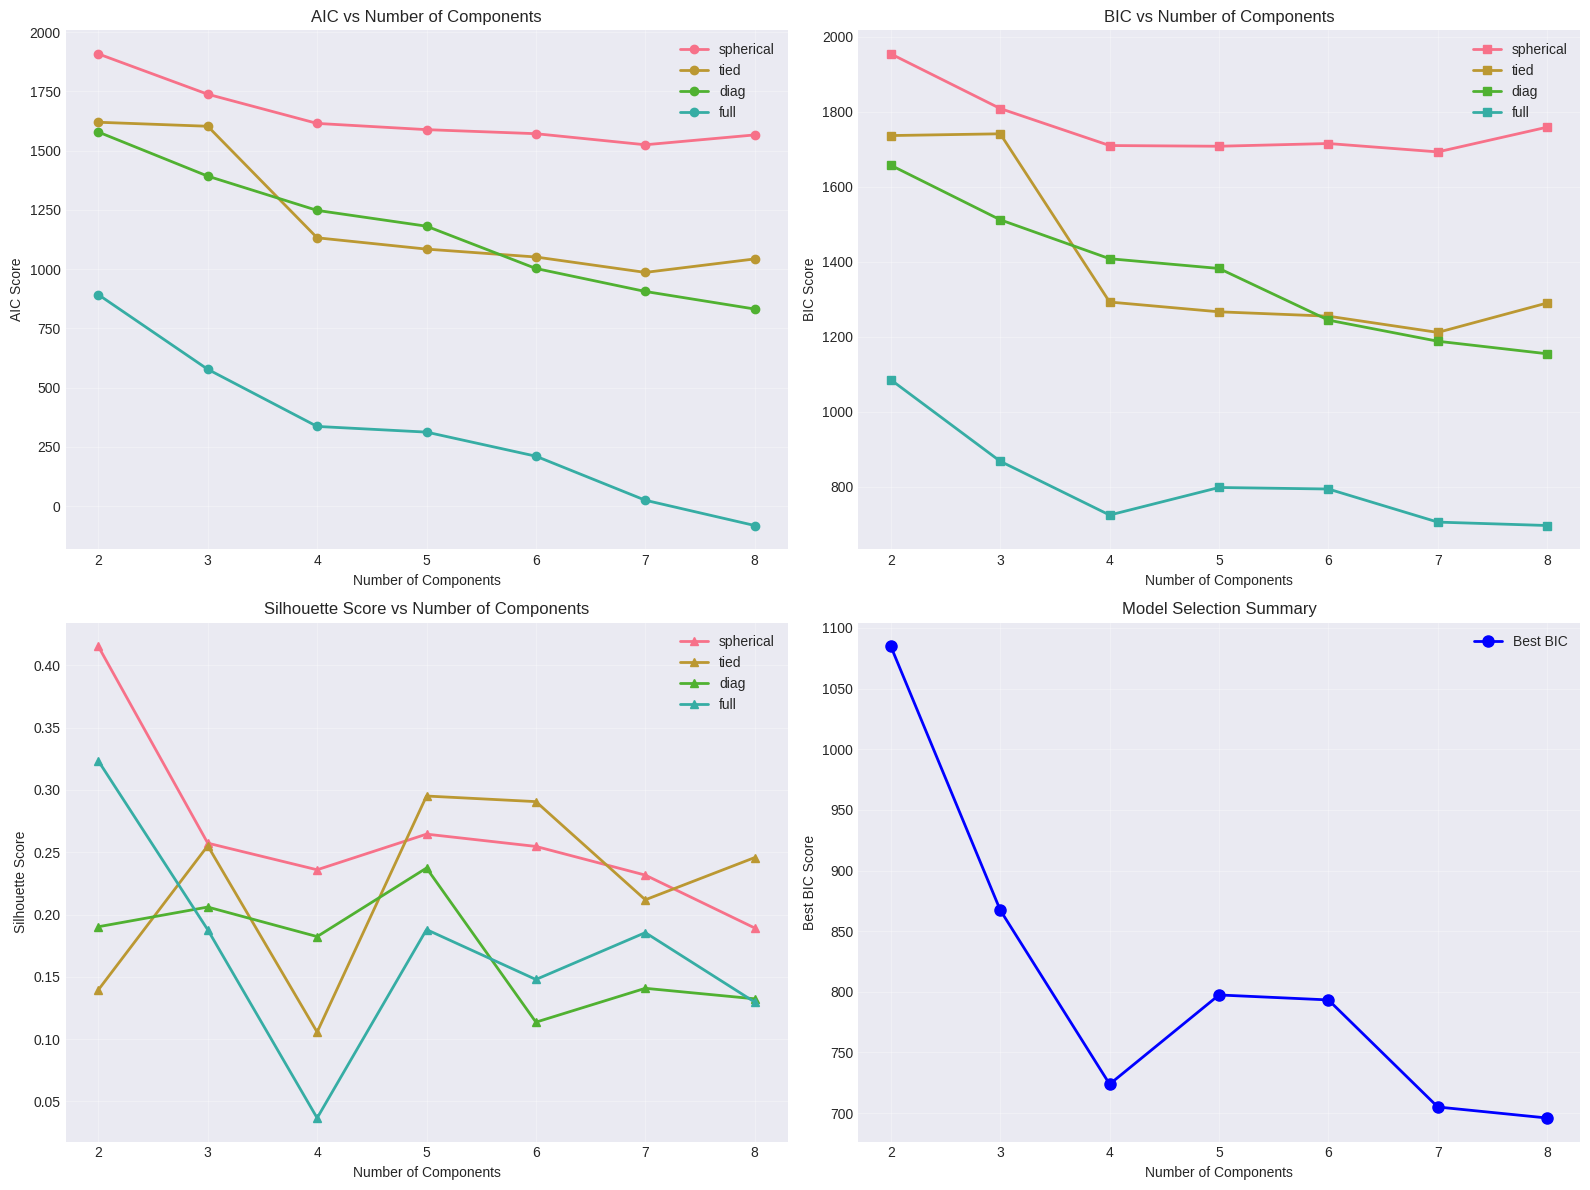


=== Model Selection Results ===
Best BIC model:
  Components: 8
  Covariance: full
  BIC: 696.0
  Silhouette: 0.130

Best Silhouette model:
  Components: 2
  Covariance: spherical
  BIC: 1954.3
  Silhouette: 0.415

=== Selected Model ===
Using 8 components with 'full' covariance

GMM Clustering Results:
Number of clusters: 8
Cluster sizes:
  Cluster 0:  35 countries (31.5%)
  Cluster 1:  22 countries (19.8%)
  Cluster 2:  30 countries (27.0%)
  Cluster 3:   1 countries ( 0.9%)
  Cluster 4:   3 countries ( 2.7%)
  Cluster 5:   2 countries ( 1.8%)
  Cluster 6:  16 countries (14.4%)
  Cluster 7:   2 countries ( 1.8%)

=== Uncertainty Analysis ===
Uncertainty distribution:
  Mean: 0.046
  Std:  0.126
  Min:  -0.000
  Max:  0.571

Countries with high classification uncertainty (top 25%):
  Argentina                 (uncertainty: 0.011)
  Asia                      (uncertainty: 0.035)
  Asia Pacific (EI)         (uncertainty: 0.013)
  Australia                 (uncertainty: 0.007)
  Bulgari

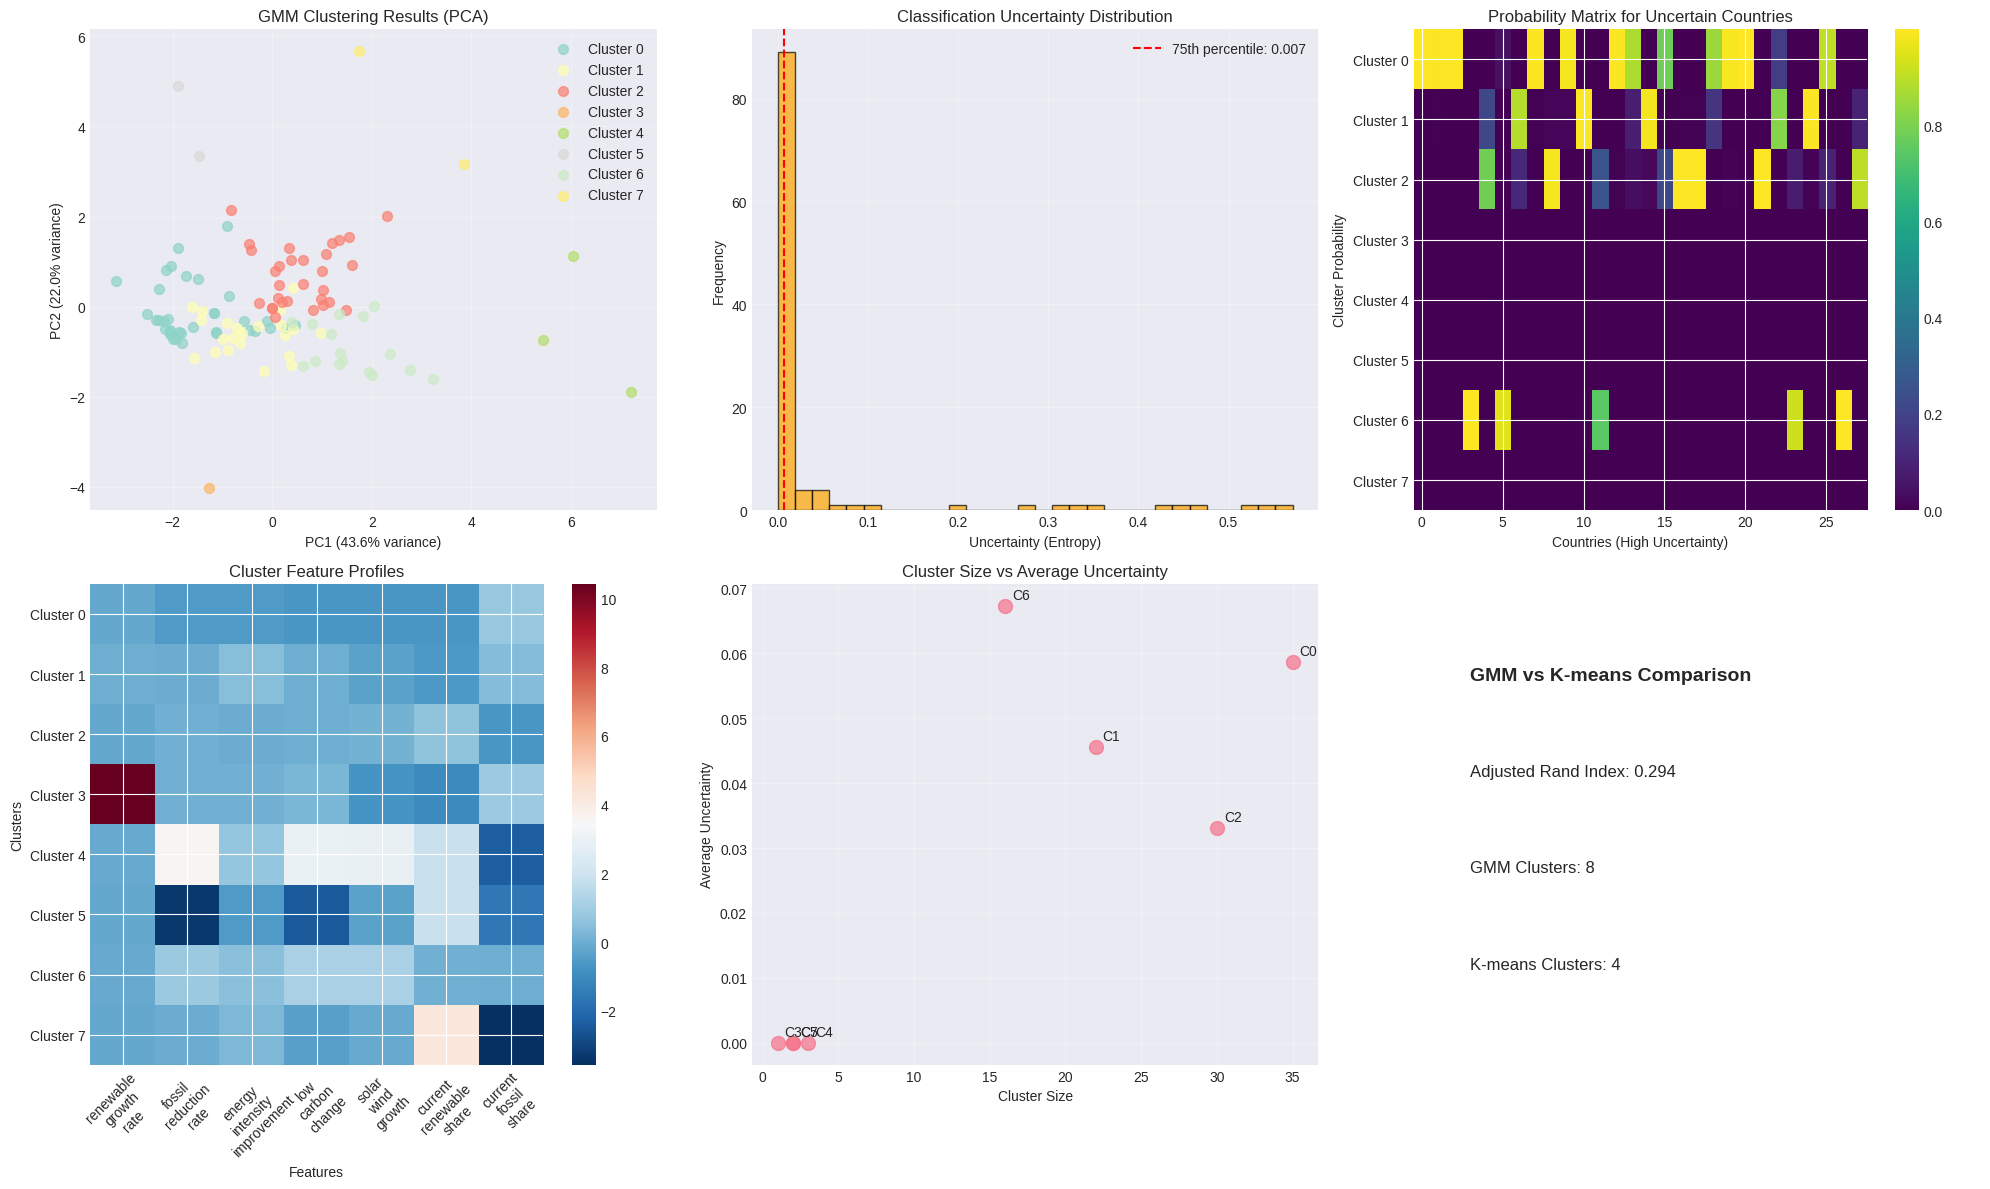


=== Cluster Characterization ===

🔹 Cluster 0 (35 countries):
   Countries: Africa, Africa (EI), Algeria, Argentina, Asia, Asia Pacific (EI), Azerbaijan, Bangladesh
   ... and 27 more
   Key characteristics:
     - Fossil Reduction Rate: Low (-0.56σ)
     - Energy Intensity Improvement: Low (-0.55σ)
     - Low Carbon Change: Low (-0.64σ)
     - Solar Wind Growth: Low (-0.62σ)
     - Current Renewable Share: Low (-0.64σ)
     - Current Fossil Share: High (+0.77σ)

🔹 Cluster 1 (22 countries):
   Countries: Belarus, Belgium, CIS (EI), Cyprus, Czechia, Hong Kong, Hungary, Indonesia
   ... and 14 more
   Key characteristics:
     - Current Renewable Share: Low (-0.61σ)

🔹 Cluster 2 (30 countries):
   Countries: Austria, Brazil, Bulgaria, Canada, Central America (EI), Colombia, Croatia, Eastern Africa (EI)
   ... and 22 more
   Key characteristics:
     - Current Renewable Share: High (+0.62σ)
     - Current Fossil Share: Low (-0.65σ)

🔹 Cluster 3 (1 countries):
   Countries: United Arab Em

In [10]:
## Gaussian Mixture Model (GMM) Clustering for Energy Transition Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

print("=== Gaussian Mixture Model Clustering Analysis ===\n")

# 1. Model Selection: Find optimal number of components and covariance type
def gmm_model_selection(X_scaled, max_components=10):
    """Find optimal GMM parameters using AIC and BIC"""
    
    n_components_range = range(2, max_components + 1)
    covariance_types = ['spherical', 'tied', 'diag', 'full']
    
    results = []
    
    print("Testing different GMM configurations...")
    print("Components | Covariance | AIC      | BIC      | Silhouette")
    print("-" * 60)
    
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            try:
                # Fit GMM
                gmm = GaussianMixture(
                    n_components=n_components,
                    covariance_type=covariance_type,
                    random_state=42,
                    max_iter=200
                )
                gmm.fit(X_scaled)
                
                # Calculate metrics
                aic = gmm.aic(X_scaled)
                bic = gmm.bic(X_scaled)
                
                # Get cluster labels and calculate silhouette score
                labels = gmm.predict(X_scaled)
                if len(set(labels)) > 1:
                    sil_score = silhouette_score(X_scaled, labels)
                else:
                    sil_score = -1
                
                results.append({
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'aic': aic,
                    'bic': bic,
                    'silhouette_score': sil_score,
                    'model': gmm
                })
                
                print(f"{n_components:^10d} | {covariance_type:^10s} | {aic:8.1f} | {bic:8.1f} | {sil_score:^10.3f}")
                
            except Exception as e:
                print(f"{n_components:^10d} | {covariance_type:^10s} | Failed: {str(e)[:20]}")
                continue
    
    return pd.DataFrame(results)

# Run model selection
gmm_results = gmm_model_selection(X_scaled, max_components=8)

# 2. Visualize model selection results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot AIC scores
for cov_type in gmm_results['covariance_type'].unique():
    data = gmm_results[gmm_results['covariance_type'] == cov_type]
    axes[0,0].plot(data['n_components'], data['aic'], marker='o', label=cov_type, linewidth=2)
axes[0,0].set_xlabel('Number of Components')
axes[0,0].set_ylabel('AIC Score')
axes[0,0].set_title('AIC vs Number of Components')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot BIC scores
for cov_type in gmm_results['covariance_type'].unique():
    data = gmm_results[gmm_results['covariance_type'] == cov_type]
    axes[0,1].plot(data['n_components'], data['bic'], marker='s', label=cov_type, linewidth=2)
axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('BIC Score')
axes[0,1].set_title('BIC vs Number of Components')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot Silhouette scores
for cov_type in gmm_results['covariance_type'].unique():
    data = gmm_results[gmm_results['covariance_type'] == cov_type]
    valid_data = data[data['silhouette_score'] > 0]
    if len(valid_data) > 0:
        axes[1,0].plot(valid_data['n_components'], valid_data['silhouette_score'], 
                      marker='^', label=cov_type, linewidth=2)
axes[1,0].set_xlabel('Number of Components')
axes[1,0].set_ylabel('Silhouette Score')
axes[1,0].set_title('Silhouette Score vs Number of Components')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Combined score plot (normalized)
axes[1,1].set_title('Model Selection Summary')
best_models = gmm_results.groupby('n_components').apply(
    lambda x: x.loc[x['bic'].idxmin()] if len(x) > 0 else None
).reset_index(drop=True)

if len(best_models) > 0:
    axes[1,1].plot(best_models['n_components'], best_models['bic'], 
                  'bo-', label='Best BIC', linewidth=2, markersize=8)
    axes[1,1].set_xlabel('Number of Components')
    axes[1,1].set_ylabel('Best BIC Score')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Select optimal model
print(f"\n=== Model Selection Results ===")

# Find best model based on BIC (generally preferred for clustering)
best_bic_model = gmm_results.loc[gmm_results['bic'].idxmin()]
best_sil_model = gmm_results.loc[gmm_results['silhouette_score'].idxmax()]

print(f"Best BIC model:")
print(f"  Components: {best_bic_model['n_components']}")
print(f"  Covariance: {best_bic_model['covariance_type']}")
print(f"  BIC: {best_bic_model['bic']:.1f}")
print(f"  Silhouette: {best_bic_model['silhouette_score']:.3f}")

print(f"\nBest Silhouette model:")
print(f"  Components: {best_sil_model['n_components']}")
print(f"  Covariance: {best_sil_model['covariance_type']}")
print(f"  BIC: {best_sil_model['bic']:.1f}")
print(f"  Silhouette: {best_sil_model['silhouette_score']:.3f}")

# Use the best BIC model for final analysis
optimal_gmm = best_bic_model['model']
optimal_n_components = best_bic_model['n_components']
optimal_covariance = best_bic_model['covariance_type']

print(f"\n=== Selected Model ===")
print(f"Using {optimal_n_components} components with '{optimal_covariance}' covariance")

# 4. Fit optimal GMM and get results
gmm_labels = optimal_gmm.predict(X_scaled)
gmm_probabilities = optimal_gmm.predict_proba(X_scaled)

# Add results to dataframe
transition_df_gmm = transition_df.copy()
transition_df_gmm['gmm_cluster'] = gmm_labels

# Add probability columns
for i in range(optimal_n_components):
    transition_df_gmm[f'prob_cluster_{i}'] = gmm_probabilities[:, i]

# Calculate uncertainty (entropy of probability distribution)
transition_df_gmm['uncertainty'] = -np.sum(
    gmm_probabilities * np.log(gmm_probabilities + 1e-10), axis=1
)

print(f"\nGMM Clustering Results:")
print(f"Number of clusters: {optimal_n_components}")
print(f"Cluster sizes:")
cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = count / len(gmm_labels) * 100
    print(f"  Cluster {cluster}: {count:3d} countries ({percentage:4.1f}%)")

# 5. Uncertainty Analysis
print(f"\n=== Uncertainty Analysis ===")
uncertainty_stats = transition_df_gmm['uncertainty'].describe()
print(f"Uncertainty distribution:")
print(f"  Mean: {uncertainty_stats['mean']:.3f}")
print(f"  Std:  {uncertainty_stats['std']:.3f}")
print(f"  Min:  {uncertainty_stats['min']:.3f}")
print(f"  Max:  {uncertainty_stats['max']:.3f}")

# Find countries with high uncertainty
high_uncertainty_threshold = uncertainty_stats['75%']
uncertain_countries = transition_df_gmm[
    transition_df_gmm['uncertainty'] > high_uncertainty_threshold
]['country'].tolist()

print(f"\nCountries with high classification uncertainty (top 25%):")
for country in uncertain_countries[:10]:  # Show top 10
    uncertainty = transition_df_gmm[transition_df_gmm['country'] == country]['uncertainty'].iloc[0]
    print(f"  {country:<25} (uncertainty: {uncertainty:.3f})")

# 6. Detailed visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: PCA visualization with GMM clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

colors = plt.cm.Set3(np.linspace(0, 1, optimal_n_components))
for i in range(optimal_n_components):
    mask = gmm_labels == i
    axes[0,0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                     c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,0].set_title('GMM Clustering Results (PCA)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Uncertainty distribution
axes[0,1].hist(transition_df_gmm['uncertainty'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].axvline(high_uncertainty_threshold, color='red', linestyle='--', 
                 label=f'75th percentile: {high_uncertainty_threshold:.3f}')
axes[0,1].set_xlabel('Uncertainty (Entropy)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Classification Uncertainty Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Probability heatmap for uncertain countries
if len(uncertain_countries) > 0:
    uncertain_data = transition_df_gmm[transition_df_gmm['country'].isin(uncertain_countries)]
    prob_columns = [f'prob_cluster_{i}' for i in range(optimal_n_components)]
    prob_matrix = uncertain_data[prob_columns].values
    
    im = axes[0,2].imshow(prob_matrix.T, cmap='viridis', aspect='auto')
    axes[0,2].set_xlabel('Countries (High Uncertainty)')
    axes[0,2].set_ylabel('Cluster Probability')
    axes[0,2].set_title('Probability Matrix for Uncertain Countries')
    axes[0,2].set_yticks(range(optimal_n_components))
    axes[0,2].set_yticklabels([f'Cluster {i}' for i in range(optimal_n_components)])
    plt.colorbar(im, ax=axes[0,2])

# Plot 4: Feature importance by cluster
cluster_means = []
for i in range(optimal_n_components):
    cluster_mask = gmm_labels == i
    cluster_mean = np.mean(X_scaled[cluster_mask], axis=0)
    cluster_means.append(cluster_mean)

cluster_means = np.array(cluster_means)
im2 = axes[1,0].imshow(cluster_means, cmap='RdBu_r', aspect='auto')
axes[1,0].set_xlabel('Features')
axes[1,0].set_ylabel('Clusters')
axes[1,0].set_title('Cluster Feature Profiles')
axes[1,0].set_xticks(range(len(clustering_features)))
axes[1,0].set_xticklabels([f.replace('_', '\n') for f in clustering_features], rotation=45)
axes[1,0].set_yticks(range(optimal_n_components))
axes[1,0].set_yticklabels([f'Cluster {i}' for i in range(optimal_n_components)])
plt.colorbar(im2, ax=axes[1,0])

# Plot 5: Cluster size vs uncertainty
cluster_uncertainties = []
for i in range(optimal_n_components):
    cluster_mask = gmm_labels == i
    cluster_uncertainty = transition_df_gmm[cluster_mask]['uncertainty'].mean()
    cluster_uncertainties.append(cluster_uncertainty)

cluster_sizes = [np.sum(gmm_labels == i) for i in range(optimal_n_components)]
axes[1,1].scatter(cluster_sizes, cluster_uncertainties, s=100, alpha=0.7)
for i, (size, unc) in enumerate(zip(cluster_sizes, cluster_uncertainties)):
    axes[1,1].annotate(f'C{i}', (size, unc), xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Cluster Size')
axes[1,1].set_ylabel('Average Uncertainty')
axes[1,1].set_title('Cluster Size vs Average Uncertainty')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Comparison with K-means (if available)
if 'kmeans_cluster' in transition_df.columns:
    # Calculate adjusted rand index
    ari_score = adjusted_rand_score(transition_df['kmeans_cluster'], gmm_labels)
    
    # Create confusion matrix
    confusion_matrix = pd.crosstab(transition_df['kmeans_cluster'], gmm_labels, margins=True)
    
    axes[1,2].text(0.1, 0.8, f'GMM vs K-means Comparison', fontsize=14, fontweight='bold')
    axes[1,2].text(0.1, 0.6, f'Adjusted Rand Index: {ari_score:.3f}', fontsize=12)
    axes[1,2].text(0.1, 0.4, f'GMM Clusters: {optimal_n_components}', fontsize=12)
    axes[1,2].text(0.1, 0.2, f'K-means Clusters: {len(transition_df["kmeans_cluster"].unique())}', fontsize=12)
    axes[1,2].set_xlim(0, 1)
    axes[1,2].set_ylim(0, 1)
    axes[1,2].axis('off')
else:
    axes[1,2].text(0.5, 0.5, 'K-means results\nnot available', 
                  ha='center', va='center', fontsize=12)
    axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# 7. Cluster characterization
print(f"\n=== Cluster Characterization ===")

for cluster_id in range(optimal_n_components):
    cluster_mask = gmm_labels == cluster_id
    cluster_countries = transition_df_gmm[cluster_mask]['country'].tolist()
    cluster_size = len(cluster_countries)
    
    print(f"\n🔹 Cluster {cluster_id} ({cluster_size} countries):")
    print(f"   Countries: {', '.join(cluster_countries[:8])}")
    if len(cluster_countries) > 8:
        print(f"   ... and {len(cluster_countries)-8} more")
    
    # Feature analysis
    cluster_features = X_scaled[cluster_mask]
    cluster_mean = np.mean(cluster_features, axis=0)
    overall_mean = np.mean(X_scaled, axis=0)
    
    print(f"   Key characteristics:")
    for i, feature in enumerate(clustering_features):
        diff = cluster_mean[i] - overall_mean[i]
        if abs(diff) > 0.5:  # Significant difference
            direction = "High" if diff > 0 else "Low"
            print(f"     - {feature.replace('_', ' ').title()}: {direction} ({diff:+.2f}σ)")

# 8. Final recommendations
print(f"\n=== GMM Analysis Summary ===")
print(f"✅ Optimal model: {optimal_n_components} components, '{optimal_covariance}' covariance")
print(f"✅ BIC score: {best_bic_model['bic']:.1f}")
print(f"✅ Silhouette score: {best_bic_model['silhouette_score']:.3f}")
print(f"✅ Average uncertainty: {transition_df_gmm['uncertainty'].mean():.3f}")

print(f"\n📊 GMM Advantages:")
print(f"   • Soft clustering: Provides membership probabilities")
print(f"   • Uncertainty quantification: Identifies ambiguous cases")
print(f"   • Flexible cluster shapes: Better than spherical K-means")
print(f"   • Statistical foundation: Probabilistic model")

print(f"\n🎯 Business Value:")
print(f"   • Probability-based policy targeting")
print(f"   • Uncertainty-aware decision making")
print(f"   • Gradual transition pathway identification")
print(f"   • Risk assessment for policy implementation")

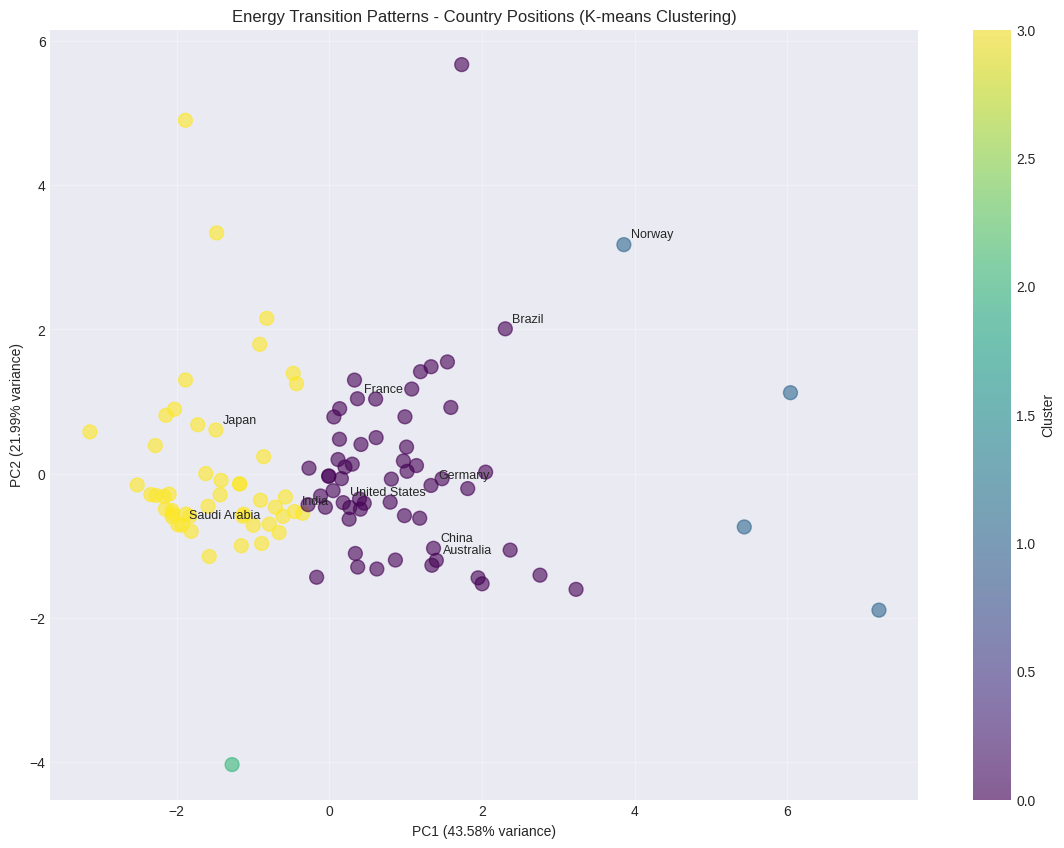

In [11]:
# 7. Visualize K-means Clustering Results
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create K-means visualization with country annotations
plt.figure(figsize=(14, 10))
plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=kmeans_labels, 
    cmap='viridis', 
    alpha=0.6, 
    s=100
)

# Annotate selected countries
countries_to_annotate = [
    'United States', 
    'China', 
    'Germany', 
    'India', 
    'Brazil',
    'Norway', 
    'Saudi Arabia', 
    'Japan', 
    'Australia', 
    'France'
]

for i, country in enumerate(transition_df['country']):
    if country in countries_to_annotate:
        plt.annotate(
            country, 
            (X_pca[i, 0], X_pca[i, 1]),
            xytext=(5, 5), 
            textcoords='offset points', 
            fontsize=9
        )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Energy Transition Patterns - Country Positions (K-means Clustering)')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Create cluster profiles
def create_cluster_profiles(df, cluster_col, features):
    """Create statistical profiles for each cluster"""
    profiles = []
    
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:  # Skip noise points for DBSCAN
            continue
            
        cluster_data = df[df[cluster_col] == cluster]
        profile = {'cluster': cluster, 'size': len(cluster_data)}
        
        # Calculate statistics for each feature
        for feature in features:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_std'] = cluster_data[feature].std()
        
        # Get example countries
        profile['example_countries'] = ', '.join(cluster_data['country'].head(5).tolist())
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create profiles for K-means clusters
kmeans_profiles = create_cluster_profiles(transition_df, 'kmeans_cluster', clustering_features)
print("K-means Cluster Profiles:")
kmeans_profiles

K-means Cluster Profiles:


,cluster,size,renewable_growth_rate_mean,renewable_growth_rate_std,fossil_reduction_rate_mean,fossil_reduction_rate_std,energy_intensity_improvement_mean,energy_intensity_improvement_std,low_carbon_change_mean,low_carbon_change_std,solar_wind_growth_mean,solar_wind_growth_std,current_renewable_share_mean,current_renewable_share_std,current_fossil_share_mean,current_fossil_share_std,example_countries
0,0,58,1.394366,3.165690,0.069847,0.038056,0.163180,0.159961,5.931069,3.337194,5.136517,2.889060,19.938379,12.341875,74.925690,12.296006,"Asia, Asia Pacific (EI), Australia, Austria, B..."
1,1,4,0.757525,0.713482,0.261775,0.079935,0.228614,0.084657,15.409750,9.096673,11.913250,5.148885,49.442750,15.314634,40.313000,14.998966,"Denmark, Finland, Norway, Sweden"
2,2,1,281.200000,NaN,0.050633,NaN,0.125504,NaN,5.063000,NaN,1.403000,NaN,1.411000,NaN,94.932000,NaN,United Arab Emirates
3,3,48,1.172714,2.925652,-0.002943,0.052674,0.025009,0.243986,0.193667,3.358418,1.393292,1.478032,8.695479,10.577215,90.339958,10.708029,"Africa, Africa (EI), Algeria, Argentina, Azerb..."


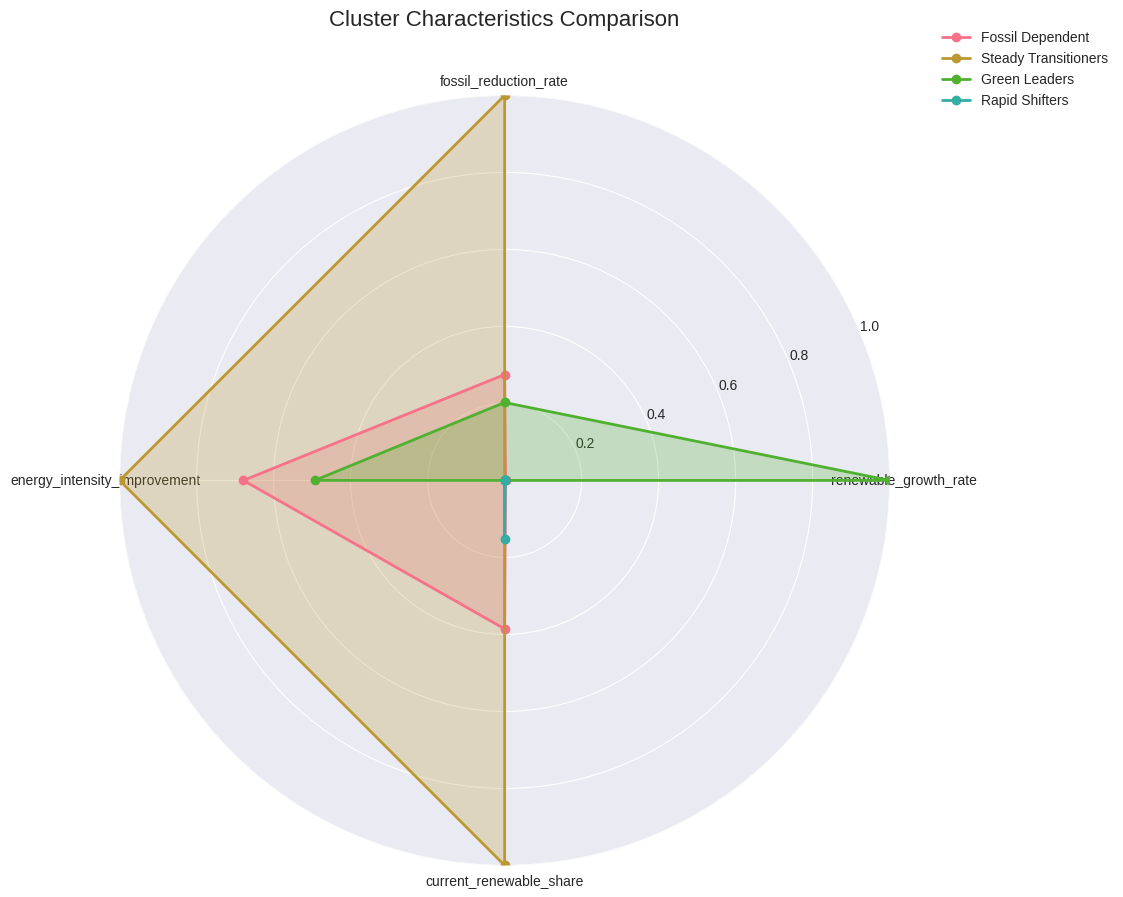

In [13]:
# Visualize cluster characteristics with radar chart
from math import pi

def create_radar_chart(df, cluster_col, features, cluster_names=None):
    """Create radar chart for cluster characteristics"""
    
    # Calculate mean values for each cluster
    cluster_means = df.groupby(cluster_col)[features].mean()
    
    # Normalize to 0-1 scale for radar chart
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    # Set up the radar chart
    categories = features
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot each cluster
    for idx, (cluster, values) in enumerate(cluster_means_norm.iterrows()):
        if cluster == -1:  # Skip noise points
            continue
            
        values = values.tolist()
        values += values[:1]
        
        cluster_name = cluster_names[cluster] if cluster_names else f'Cluster {cluster}'
        ax.plot(angles, values, 'o-', linewidth=2, label=cluster_name)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.set_ylim(0, 1)
    ax.set_title('Cluster Characteristics Comparison', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    return fig

# Define cluster names based on characteristics
cluster_names = {
    0: 'Fossil Dependent',
    1: 'Steady Transitioners',
    2: 'Green Leaders',
    3: 'Rapid Shifters'
}

# Create radar chart
radar_fig = create_radar_chart(transition_df, 'kmeans_cluster', 
                              ['renewable_growth_rate', 'fossil_reduction_rate', 
                               'energy_intensity_improvement', 'current_renewable_share'], 
                              cluster_names)
plt.show()

In [14]:
# Classify countries as developed/developing based on GDP per capita
# Using World Bank threshold: $12,000 GDP per capita
gdp_threshold = 12000
transition_df['development_status'] = transition_df['gdp_per_capita'].apply(
    lambda x: 'Developed' if x >= gdp_threshold else 'Developing'
)

# Handle missing GDP data
transition_df.loc[transition_df['gdp_per_capita'].isna(), 'development_status'] = 'Unknown'

print("Development status distribution:")
print(transition_df['development_status'].value_counts())

Development status distribution:
development_status
Developed     66
Developing    45
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

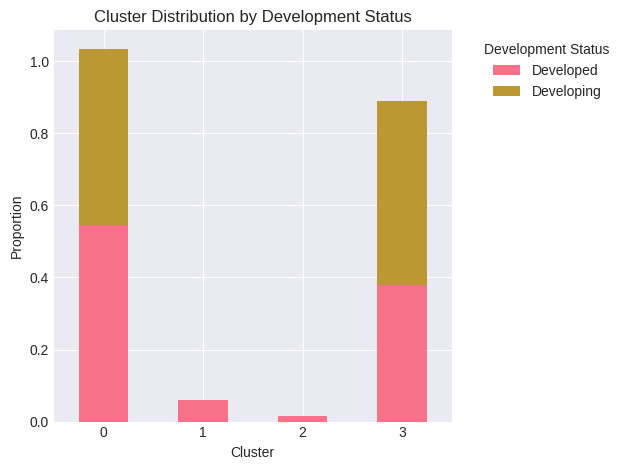

In [15]:
# Analyze cluster distribution by development status
cluster_dev_crosstab = pd.crosstab(transition_df['kmeans_cluster'], 
                                   transition_df['development_status'], 
                                   normalize='columns')

# Visualize
plt.figure(figsize=(10, 6))
cluster_dev_crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Distribution by Development Status')
plt.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

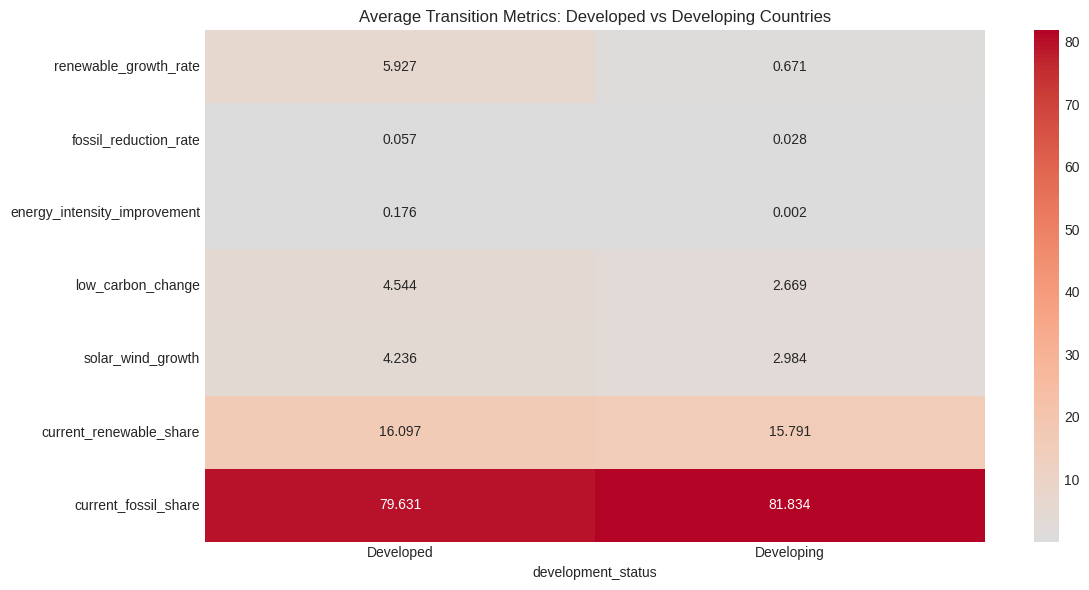

In [16]:
# Statistical comparison between developed and developing countries
dev_comparison = transition_df[transition_df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status')[clustering_features].mean()

# Create comparison heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dev_comparison.T, annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Average Transition Metrics: Developed vs Developing Countries')
plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

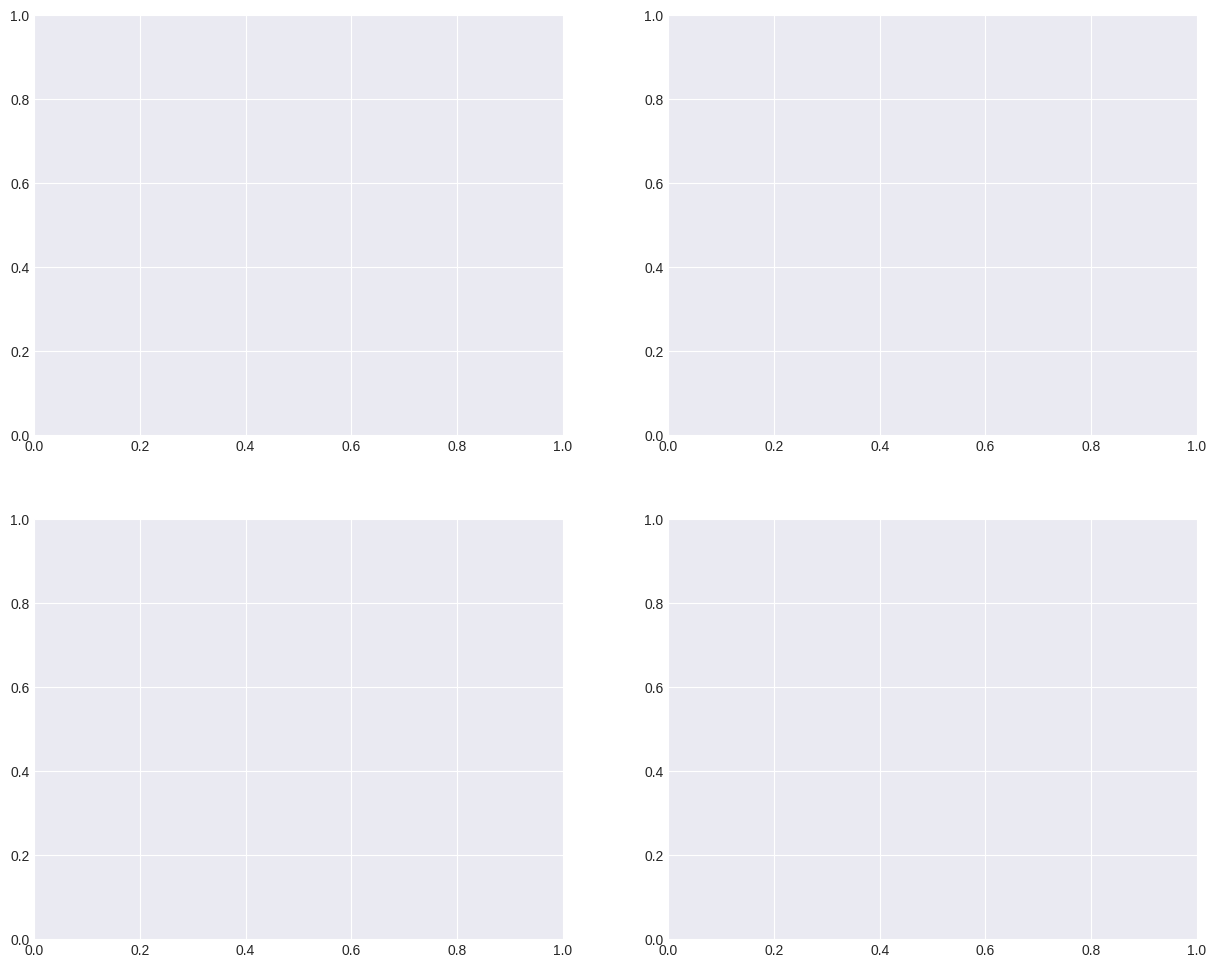

In [23]:
# Compare noise countries with main clusters
noise_countries = outlier_countries
if len(noise_countries) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    features_to_compare = ['renewable_growth_rate', 'fossil_reduction_rate', 
                          'current_renewable_share', 'energy_intensity_improvement']
    
    for i, feature in enumerate(features_to_compare):
        # Box plot comparing clusters and noise
        data_to_plot = []
        labels = []
        
        for cluster in sorted(transition_df['kmeans_cluster'].unique()):
            cluster_data = transition_df[transition_df['kmeans_cluster'] == cluster][feature].dropna()
            data_to_plot.append(cluster_data)
            labels.append(f'Cluster {cluster}')
        
        # Add noise points
        noise_data = noise_countries[feature].dropna()
        if len(noise_data) > 0:
            data_to_plot.append(noise_data)
            labels.append('Unique Cases')
        
        axes[i].boxplot(data_to_plot, labels=labels)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)
        
        # Rotate x labels if needed
        if len(labels) > 4:
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [54]:
# Create summary report
def create_summary_report(df, cluster_col='kmeans_cluster'):
    """Create a comprehensive summary of transition patterns"""
    
    print("=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===\n")
    
    # 1. Overall patterns
    print("1. IDENTIFIED TRANSITION PATTERNS:")
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:
            continue
        cluster_countries = df[df[cluster_col] == cluster]
        cluster_name = cluster_names.get(cluster, f"Cluster {cluster}")
        print(f"\n{cluster_name} ({len(cluster_countries)} countries):")
        print(f"  - Average renewable share: {cluster_countries['current_renewable_share'].mean():.1f}%")
        print(f"  - Average fossil reduction: {cluster_countries['fossil_reduction_rate'].mean():.1%}")
        print(f"  - Example countries: {', '.join(cluster_countries['country'].head(3).tolist())}")
    
    # 2. Development divide
    print("\n\n2. DEVELOPED vs DEVELOPING COUNTRIES:")
    dev_stats = df[df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status').agg({
        'renewable_growth_rate': 'mean',
        'fossil_reduction_rate': 'mean',
        'current_renewable_share': 'mean'
    })
    print(dev_stats)
    
    # 3. Special cases
    print("\n\n3. COUNTRIES WITH UNIQUE PATTERNS:")
    unique_countries = df[df['dbscan_cluster'] == -1]
    if len(unique_countries) > 0:
        for _, country in unique_countries.iterrows():
            print(f"  - {country['country']}: {country['current_renewable_share']:.1f}% renewable")
    
    # 4. Policy recommendations
    print("\n\n4. KEY INSIGHTS FOR POLICY:")
    print("  - Green Leaders show that >80% renewable energy is achievable")
    print("  - Rapid Shifters demonstrate that fast transition is possible with right policies")
    print("  - Developing countries need different support than developed nations")
    print("  - Special attention needed for Fossil Dependent countries")

# Generate summary report
create_summary_report(transition_df)

=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===

1. IDENTIFIED TRANSITION PATTERNS:

Fossil Dependent (58 countries):
  - Average renewable share: 19.9%
  - Average fossil reduction: 7.0%
  - Example countries: Asia, Asia Pacific (EI), Australia

Steady Transitioners (4 countries):
  - Average renewable share: 49.4%
  - Average fossil reduction: 26.2%
  - Example countries: Denmark, Finland, Norway

Green Leaders (1 countries):
  - Average renewable share: 1.4%
  - Average fossil reduction: 5.1%
  - Example countries: United Arab Emirates

Rapid Shifters (48 countries):
  - Average renewable share: 8.7%
  - Average fossil reduction: -0.3%
  - Example countries: Africa, Africa (EI), Algeria


2. DEVELOPED vs DEVELOPING COUNTRIES:
                    renewable_growth_rate  fossil_reduction_rate  \
development_status                                                 
Developed                        5.927383               0.057030   
Developing                       0.670808             

In [20]:
# Export results for further analysis
output_df = transition_df[['country', 'kmeans_cluster', 'development_status'] + clustering_features]
output_df['cluster_name'] = output_df['kmeans_cluster'].map(cluster_names)

# Save to CSV
output_df.to_csv('energy_transition_clusters.csv', index=False)
print("\nResults saved to 'energy_transition_clusters.csv'")

# Display final clustering results
print("\nFinal clustering results (first 20 countries):")
output_df.head(20)


Results saved to 'energy_transition_clusters.csv'

Final clustering results (first 20 countries):


,country,kmeans_cluster,development_status,renewable_growth_rate,fossil_reduction_rate,energy_intensity_improvement,low_carbon_change,solar_wind_growth,current_renewable_share,current_fossil_share,cluster_name
0,Africa,3,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
1,Africa (EI),3,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
2,Algeria,3,Developed,1.111111,0.001201,-0.264887,0.120,0.217,0.228,99.772,Rapid Shifters
3,Argentina,3,Developed,0.082762,0.007134,-0.042743,0.619,4.217,12.010,86.146,Rapid Shifters
4,Asia,0,Developing,1.025413,0.059558,0.000000,5.479,4.157,11.397,86.515,Fossil Dependent
5,Asia Pacific (EI),0,Developing,1.071019,0.069329,0.000000,6.305,4.812,13.006,84.638,Fossil Dependent
6,Australia,0,Developed,2.240460,0.095494,0.186430,9.159,9.047,13.247,86.753,Fossil Dependent
7,Austria,0,Developed,0.166739,0.071845,0.230707,5.021,5.877,35.134,64.866,Fossil Dependent
8,Azerbaijan,3,Developed,-0.688363,-0.051979,-0.347191,-4.833,0.167,2.188,97.812,Rapid Shifters
9,Bangladesh,3,Developing,-0.169065,-0.001422,0.049363,-0.141,0.262,0.693,99.307,Rapid Shifters


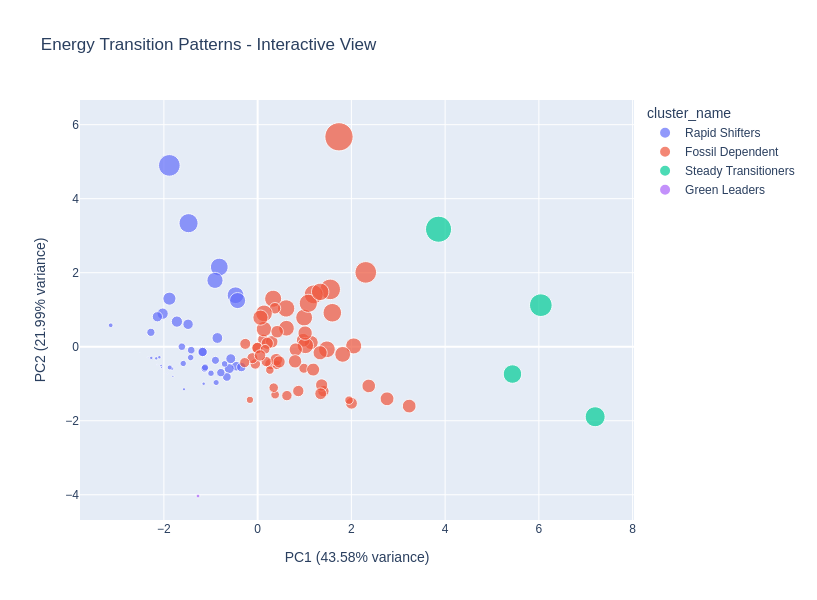

In [21]:
# Create an interactive scatter plot using plotly
import plotly.express as px

# Prepare data for interactive plot
plot_df = transition_df.copy()
plot_df['pca1'] = X_pca[:, 0]
plot_df['pca2'] = X_pca[:, 1]
plot_df['cluster_name'] = plot_df['kmeans_cluster'].map(cluster_names)

# Handle NaN values in size column
# Option 1: Fill NaN with median value
plot_df['size_for_plot'] = plot_df['current_renewable_share'].fillna(plot_df['current_renewable_share'].median())

# Create interactive scatter plot
fig = px.scatter(plot_df, 
                 x='pca1', 
                 y='pca2', 
                 color='cluster_name',
                 hover_data=['country', 'current_renewable_share', 'fossil_reduction_rate', 'development_status'],
                 hover_name='country',
                 title='Energy Transition Patterns - Interactive View',
                 labels={'pca1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
                         'pca2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'},
                 size='size_for_plot',
                 size_max=20)

fig.update_layout(height=600, width=900)
fig.show()